In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift
from typing import Tuple

%matplotlib inline

In [36]:
def sin_tick(n: int) -> Tuple[np.ndarray, np.ndarray]:
    x = np.linspace(0, 1, n, endpoint=True)
    y = np.sin(2 * np.pi * x)
    return x, y

# FFT

[scipy.fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html)

`fft(x, n)` - Return discrete Fourier transform of real or complex sequence.

`fftshift(x)` - Shift the zero-frequency component to the center of the spectrum.




 N=10000


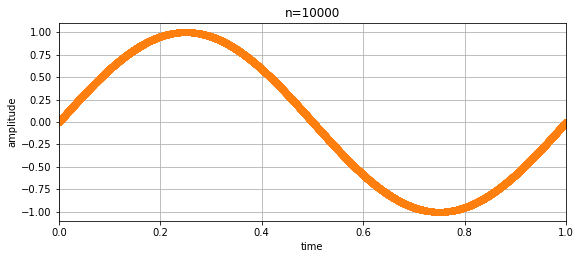

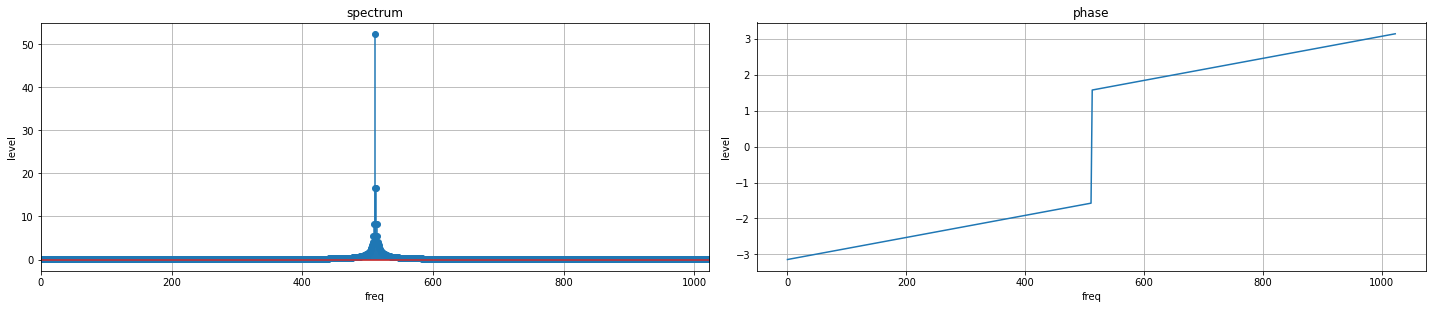




 N=5000


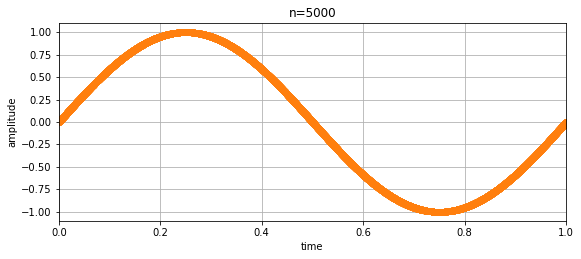

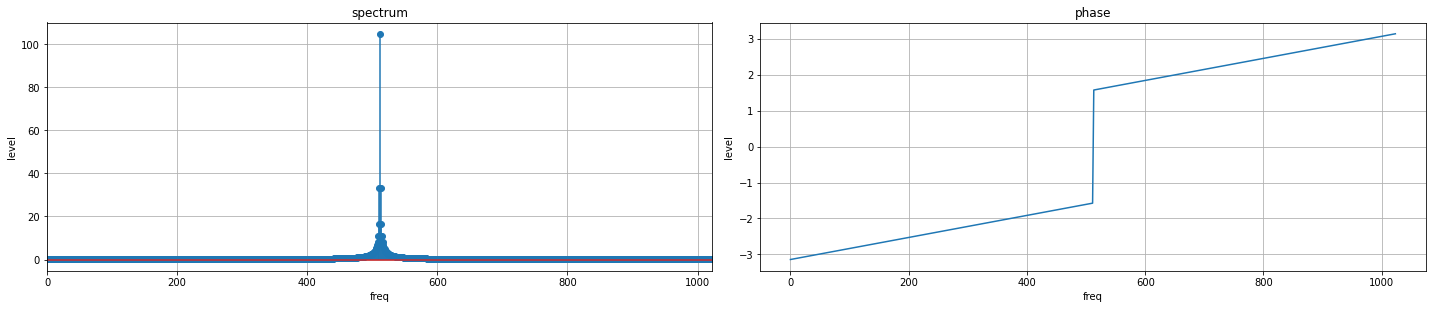




 N=500


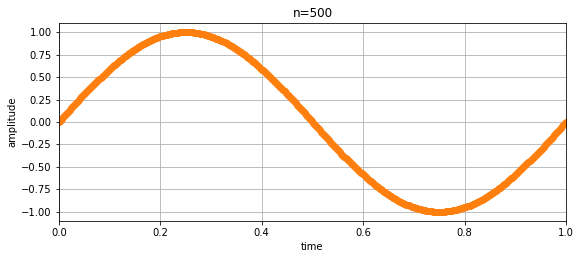

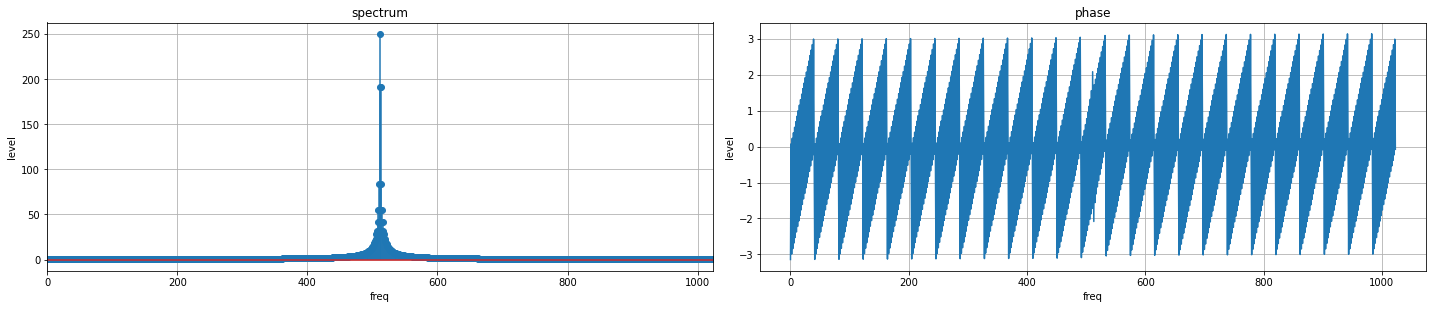




 N=100


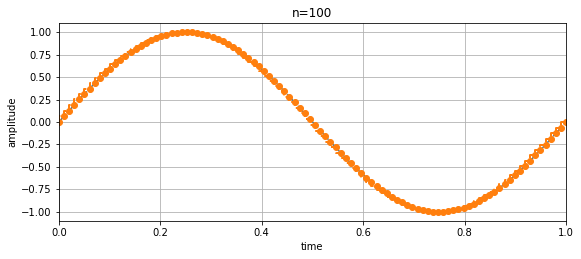

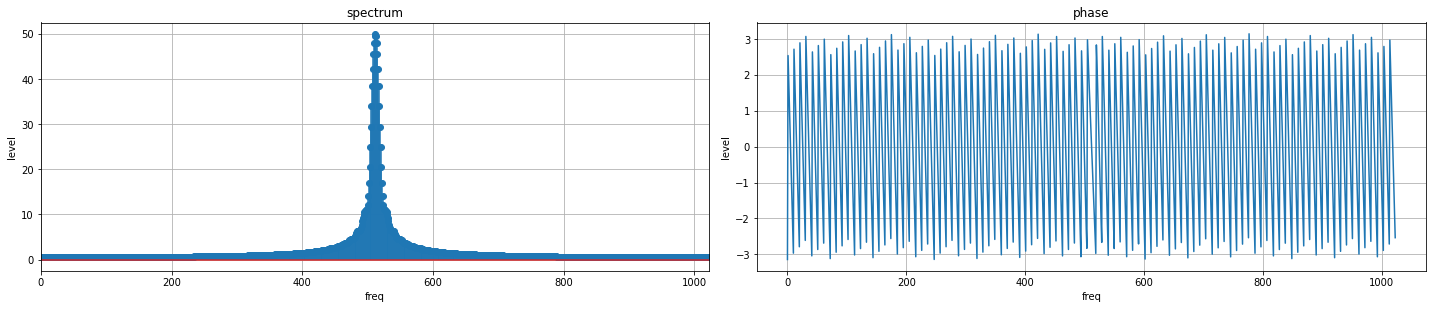




 N=25


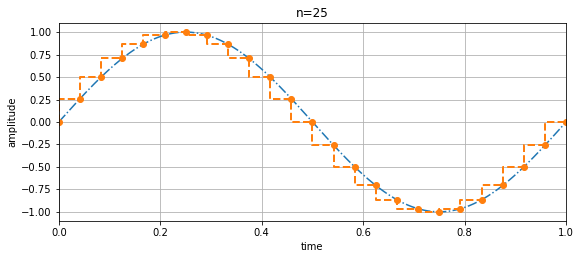

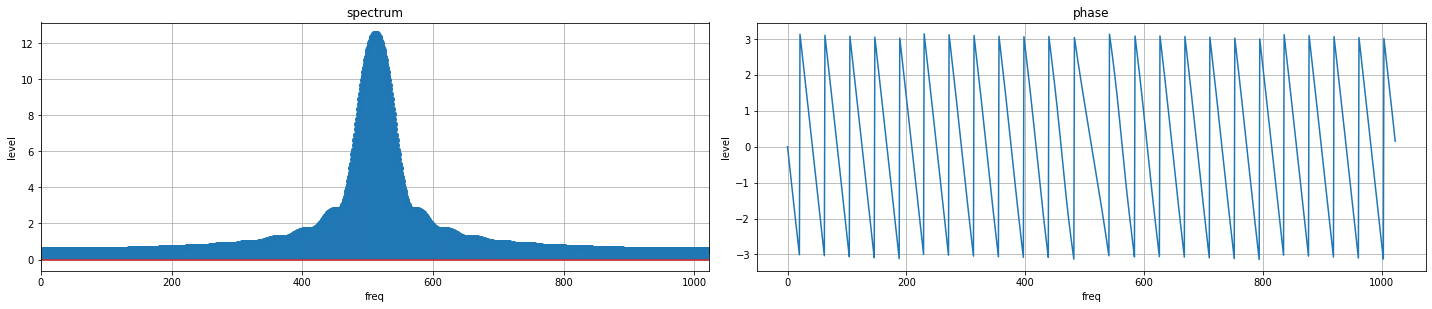




 N=10


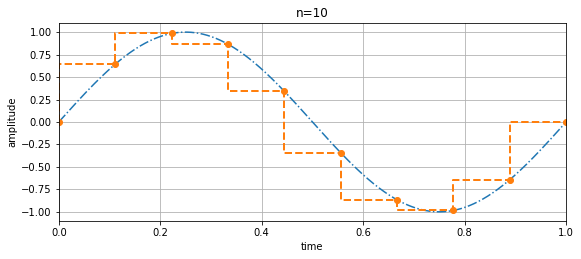

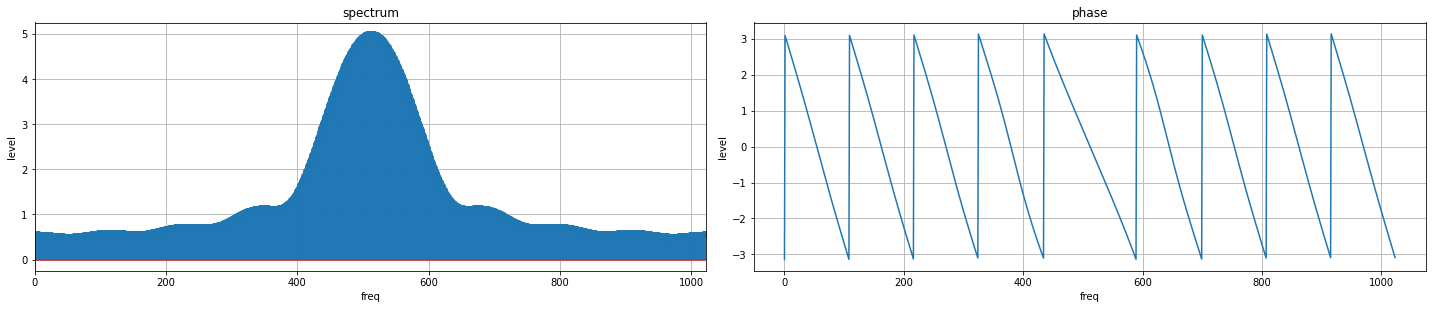

In [62]:
ideal_x, ideal_y = sin_tick(10000)

N_FFT = 1024

for i, n in enumerate((10000, 5000, 500, 100, 25, 10)):
    print(f"\n\n\n N={n}")
    fig = plt.figure(figsize=(20, 8))
    plt.subplot(2, 2, 1)
    plt.xlim([0, 1])
    plt.grid()
    plt.title(f'n={n}')
    plt.plot(ideal_x, ideal_y, '-.')  # ideal
    x, y = sin_tick(n)
    plt.step(x, y, '--o', linewidth=2.0)
    plt.xlabel("time")
    plt.ylabel("amplitude")
    
    x_fft = fftshift(fft(x, N_FFT))

    fig = plt.figure(figsize=(20, 8))
    
    # spectrum
    plt.subplot(2, 2, 3)
    plt.grid()
    plt.title('spectrum')
    plt.xlabel("freq")
    plt.ylabel("level")
    plt.xlim([0, N_FFT-1])
    plt.stem(np.abs(x_fft))
    
    # phase
    plt.subplot(2, 2, 4)
    plt.grid()
    plt.title('phase')
    plt.xlabel("freq")
    plt.ylabel("level")
    plt.plot(np.angle(x_fft))
    
    plt.tight_layout()
    plt.show()
